In [2]:
import numpy as np
import math
import scipy
import scipy.linalg  
import time
import scipy.sparse as sparse
import scipy.sparse.linalg
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from pyDOE import lhs
import tensorflow as tf

u_xx + u_yy = -2 xsin(pi cx)sin(pi cy) on [0,1]^2

Boundaries Known (taken from Above solution)

Solution u = sin(cx) sin(cy)

In [64]:
width = 20
depth = 6
optm = tf.keras.optimizers.Adam(amsgrad=True)
const = math.pi
def get_model():
    model=Sequential([Dense(width,activation='tanh',
                            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                            input_shape=(None,2),name='H1')])
    for i in range(depth):
        model.add(Dense(width,activation='tanh',name='H'+str(i+2)))
    model.add(Dense(1,name='output_layer'))
    return model
def u(data):
    output = model(data)
    return output[:,0]
def p2t(x,y):
    #point to tensor for inputs
    output = tf.Variable(np.array([x,y]).T, dtype=tf.float32)
    return output
def f(data):
    with tf.GradientTape(persistent = True) as tp1:
        tp1.watch(data)
        with tf.GradientTape() as tp2:
            tp2.watch(data)
            sol = u(data)
        grad= tp2.gradient(sol, data)
        u_x = grad[:, 0]
        u_y = grad[:, 1]
    u_xx = tp1.gradient(u_x, data)[:, 0]
    u_yy = tp1.gradient(u_y, data)[:,1]
    output = u_xx+u_yy
    return output
def u_exact(data):
    return tf.math.sin(const*data[:, 0])*tf.math.sin(const*data[:, 1])
def f_exact(data):
    return -(2*const**2)*u_exact(data)
def PINN_loss(data):
    output = tf.reduce_mean(tf.math.square(f_exact(data)-f(data)))
    return output
def MSE_loss(data):
    output = tf.reduce_mean(tf.math.square(u_exact(data)-u(data)))
    return output

def ode_system(bddata, intdata): 
    total_loss = PINN_loss(intdata)+MSE_loss(bddata)
    
    return total_loss

def train_model(bddata, intdata, max_it):
    loss_history = []
    for itr in range(max_it):
        with tf.GradientTape() as tape:
            train_loss = ode_system(bddata, intdata)
            grads = tape.gradient(train_loss, model.trainable_variables)
            optm.apply_gradients(zip(grads, model.trainable_variables))

        if itr % 100 == 0:
            print(train_loss.numpy())
            loss_history.append(train_loss.numpy())
    return model, loss_history

def whole_input(xnum, ynum):
    x = np.linspace(0, 1, xnum)
    y = np.linspace(0, 1, ynum)
    xv, yv = np.meshgrid(x, y)
    xv = np.concatenate(xv)
    yv = np.concatenate(yv)
    output = p2t(xv, yv)
    return output
def bound_input(xnum, ynum):
    x = np.linspace(0, 1, xnum)
    y = np.linspace(0, 1, ynum)
    top = p2t(x, np.zeros(xnum))
    bottom = p2t(x, np.ones(xnum))
    left = p2t(np.zeros(ynum), y)
    right = p2t(np.ones(ynum), y)
    output = np.vstack((top, bottom, left, right))
    output = np.unique(output, axis = 0)
    
    return output
def plotter(model, loss_history):
    data = whole_input(100, 100)
    approx = model(data)[:,0].numpy()
    exact = u_exact(data).numpy()
    abs_error = abs(exact - approx)
    MAE_error = (abs_error).mean()
    print("Mean Absolute Error: " + str(MAE_error))
    rel_L2_err = np.linalg.norm(exact-approx)/np.linalg.norm(exact) 
    print("Relative L2 Error: " + str(rel_L2_err))
    print("Error Max "+ str(abs_error.max()))
    print("Error Min "+ str(abs_error.min()))
    x = data[:, 0].numpy()
    y = data[:, 1].numpy()
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 1, 1)
    plt.tricontourf(x, y, abs_error ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Absolute Error")
    #plt.plot()
    
    plt.subplot(3, 1, 2)
    plt.tricontourf(x, y, approx ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Predicted")
    
    plt.subplot(3, 1, 3)
    plt.tricontourf(x, y, exact ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Exact")
    
    plt.figure()
    plt.plot(loss_history, label="Loss")
    plt.legend()
    plt.show()
    
    return 
def main(xnum, ynum, max_it):
    intdata = whole_input(xnum, ynum)
    bddata = bound_input(xnum, ynum)
    model, loss_history = train_model(bddata, intdata, max_it)
    plotter(model, loss_history)

118.66227
8.374454
0.72621495
0.28007376
0.11734414
0.07667185
0.069348745
0.064249694
0.059703093
0.055534497
Mean Absolute Error: 0.06247043
Relative L2 Error: 0.15072687
Error Max 0.27773413
Error Min 4.351139e-06


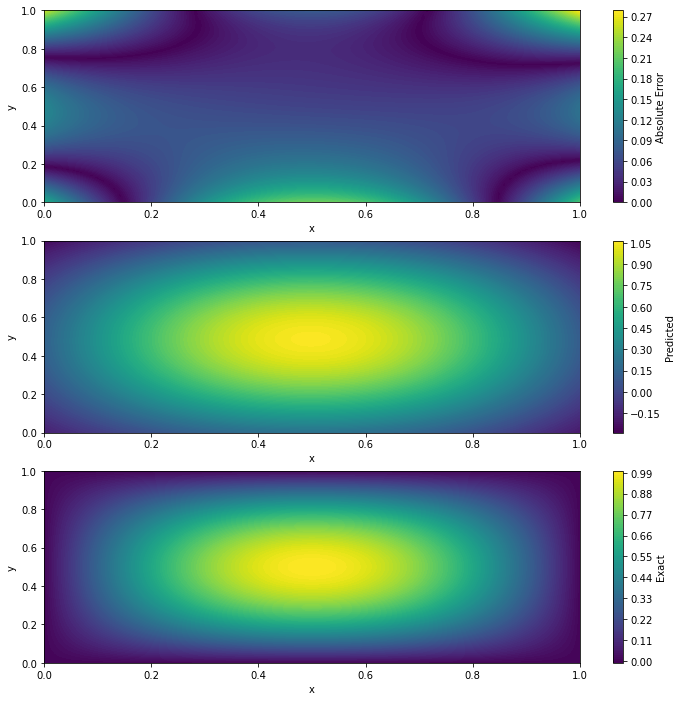

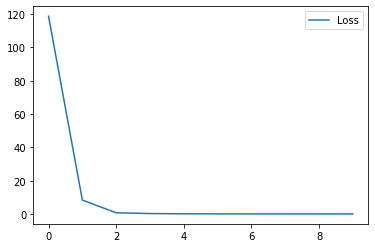

In [65]:
tf.random.set_seed(1234)
model  = get_model()
main(100, 1000, 1000)